In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
# plt.style.use("science")
import pandas as pd
import warnings

from synthpop.models.ultravox_populi import UltravoxPopuli
from synthpop.optimise import Optimise, VO, TBS_SMC
from synthpop.generative import MaskedAutoRegressiveFlow, SampleGenerator
import pygtc

In [6]:
n_agents = 500
n_timesteps = 500
model = UltravoxPopuli(n_timesteps=n_timesteps, n_agents=n_agents)

# Define "complexity" of the signal as total variation (i.e. one-variation) of series
# Maximum value of one-variation of piecewise linear path in [0,1] over N unit increments is N - 1,
# so consider distance below this maximum value
# Regularise by penalising time spent in absorbing states at (mean_opinion = 1) and (mean_opinion = 0)
def sbi_one_variation(x):
    x = x[0]
    regularisation = (x < 1./n_agents).sum() + (x > 1 - 1./n_agents).sum()
    variance = (pd.DataFrame(x).rolling(10).std()**2).sum().values[0] 
    return variance + regularisation

### SMC ABC

In [7]:
# sample meta generator
class SampleMetaGenerator(SampleGenerator):
    def forward(self, generator_params):
        # append m to 2
        return UltravoxPopuli.make_default_generator(generator_params)

In [8]:
# Parameters: 
# Probability for Bernoulli random variable that assigns initial opinions to each agent; 
# Two parameters for Beta distribution over stubbornness parameter 1
# Same again for second stubbornness parameter
dom_min = [0.,0.,0.,0.,0.]
dom_max = [1.,5.,5.,5.,5.]
dom = torch.distributions.Independent(torch.distributions.Uniform(torch.tensor(dom_min), torch.tensor(dom_max)), 1)

In [10]:
sample_meta_generator = SampleMetaGenerator()
optimise = Optimise(model=model, meta_generator=sample_meta_generator, prior=dom, loss=sbi_one_variation)
optimise_method = TBS_SMC(num_particles = 10_000, num_initial_pop=20_000, num_simulations=50_000, epsilon_decay=0.8)
trained_meta_generator = optimise.fit(optimise_method, num_workers=-1)

Running 20000 simulations in 20000 batches.:   0%|          | 0/20000 [00:00<?, ?it/s]

/Users/joeyer/Documents/Code/synthpop/synthpop/lib/python3.10/site-packages/sbi/inference/abc/smcabc.py:569: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1702.)
  torch.cholesky(kernel_variance_scale * population_cov)


Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 5322 simulations in 5322 batches.:   0%|          | 0/5322 [00:00<?, ?it/s]

Running 2840 simulations in 2840 batches.:   0%|          | 0/2840 [00:00<?, ?it/s]

Running 1509 simulations in 1509 batches.:   0%|          | 0/1509 [00:00<?, ?it/s]

Running 826 simulations in 826 batches.:   0%|          | 0/826 [00:00<?, ?it/s]

Running 434 simulations in 434 batches.:   0%|          | 0/434 [00:00<?, ?it/s]

Running 217 simulations in 217 batches.:   0%|          | 0/217 [00:00<?, ?it/s]

Running 120 simulations in 120 batches.:   0%|          | 0/120 [00:00<?, ?it/s]

Running 74 simulations in 74 batches.:   0%|          | 0/74 [00:00<?, ?it/s]

Running 39 simulations in 39 batches.:   0%|          | 0/39 [00:00<?, ?it/s]

Running 18 simulations in 18 batches.:   0%|          | 0/18 [00:00<?, ?it/s]

Running 13 simulations in 13 batches.:   0%|          | 0/13 [00:00<?, ?it/s]

Running 8 simulations in 8 batches.:   0%|          | 0/8 [00:00<?, ?it/s]

Running 2 simulations in 2 batches.:   0%|          | 0/2 [00:00<?, ?it/s]

Running 8576 simulations in 8576 batches.:   0%|          | 0/8576 [00:00<?, ?it/s]

In [11]:
untrained_sample_meta_generator = SampleMetaGenerator()
n_runs = 7
prior_runs = [model.run(untrained_sample_meta_generator(dom.sample())) for _ in range(n_runs)]
trained_runs = [model.run(trained_meta_generator()) for i in range(n_runs)]
avg_loss = np.mean([sbi_one_variation(xx) for xx in trained_runs])
print(f"Average loss is {avg_loss}")

Average loss is 0.2249924761904539


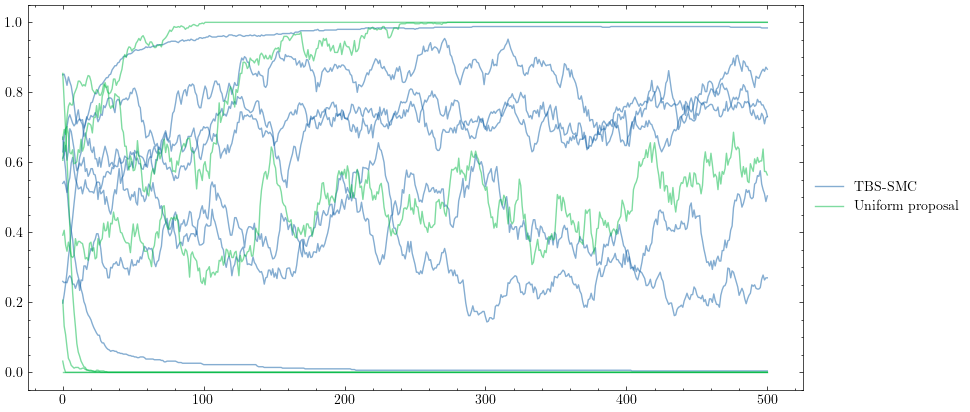

In [12]:
f, ax = plt.subplots(figsize=(10,5))
alpha = 0.5
for run in trained_runs:
    ax.plot(run[0], alpha = 0.5, color = "C0")

for run in prior_runs:
    ax.plot(run[0], alpha = 0.5, color = "C1")

ax.plot([], [], alpha=alpha, color="C0", label = "TBS-SMC")
ax.plot([], [], alpha=alpha, color="C1", label = "Uniform proposal")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Variational Optimisation

In [16]:
dom_min = torch.zeros(5)
dom_max = torch.tensor([1, 5, 5, 5, 5.])
class FlowMetaGenerator(MaskedAutoRegressiveFlow):
    dom_min = dom_min
    dom_max = dom_max
    def forward(self, generator_params=None):
        with torch.no_grad():
            if generator_params is None:
                generator_params = self.sample(1)[0][0]
            # adjust parameters to adequate range
            generator_params = torch.sigmoid(generator_params)
            generator_params = self.dom_min + (self.dom_max - self.dom_min) * generator_params
        return UltravoxPopuli.make_default_generator(generator_params.numpy())

In [20]:
n_parameters = 5
flow_meta_generator = FlowMetaGenerator(min_values=dom_min, 
                                        max_values=dom_max,
                                        n_parameters=5, 
                                        n_transforms=4, 
                                        n_hidden_units=32)
# make aux prior so that regularisation loss is the entropy.
inff = 1000
dom_vo = torch.distributions.Independent(torch.distributions.Uniform(-inff * torch.ones(n_parameters), inff * torch.ones(n_parameters)), 1)
optimise = Optimise(model=model, meta_generator=flow_meta_generator, prior=dom_vo, loss=sbi_one_variation)
optimizer = torch.optim.AdamW(flow_meta_generator.parameters(), lr=1e-3)
optimise_method = VO(w=1., 
                     n_samples_per_epoch=20, 
                     optimizer=optimizer, 
                     progress_bar=True, 
                     progress_info=True, 
                     gradient_estimation_method="score", 
                     log_tensorboard=True, 
                     n_samples_regularisation=10000)
optimise.fit(optimise_method, n_epochs=500, max_epochs_without_improvement=50);

 24%|█████████████████████████████████████▉                                                                                                                       | 121/500 [01:00<03:10,  1.99it/s, loss=9.11, reg.=35.5, total=44.6, best loss=0.361, epochs since improv.=50]


In [21]:
flow_meta_generator.load_state_dict(torch.load("./best_estimator.pt"))
flow_trained_runs = [model.run(flow_meta_generator()) for _ in range(n_runs)]
avg_loss = np.mean([sbi_one_variation(xx) for xx in flow_trained_runs])
print(f"Averaged loss: {avg_loss}")

Averaged loss: 46.014007307936495


Text(0, 0.5, 'Average population opinion')

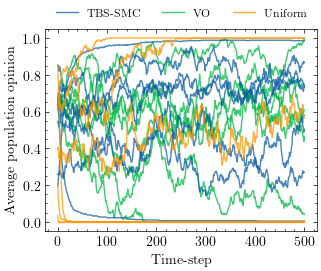

In [22]:
f, ax = plt.subplots()
alpha = 0.75
n_to_plot = 10
for run in flow_trained_runs[:n_to_plot]:
    ax.plot(run[0], alpha = alpha, color = "C1")
    
for run in trained_runs[:n_to_plot]:
    ax.plot(run[0], alpha = alpha, color = "C0")

for run in prior_runs[:n_to_plot]:
    ax.plot(run[0], alpha = alpha, color = "C2")

ax.plot([], [], alpha=alpha, color="C0", label = "TBS-SMC")
ax.plot([], [], alpha=alpha, color="C1", label = "VO")
ax.plot([], [], alpha=alpha, color="C2", label = "Uniform")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize=8)
ax.set_xlabel("Time-step")
ax.set_ylabel("Average population opinion")
# f.savefig("../figures/paper/ultravox_opinions.pdf", bbox_inches="tight")

In [23]:
with torch.no_grad():
    samples_flow = flow_meta_generator.sample(10000)[0]
    samples_flow = torch.sigmoid(samples_flow)
    samples_flow = flow_meta_generator.dom_min + (flow_meta_generator.dom_max - flow_meta_generator.dom_min) * samples_flow
samples_abc = trained_meta_generator.samples.numpy()

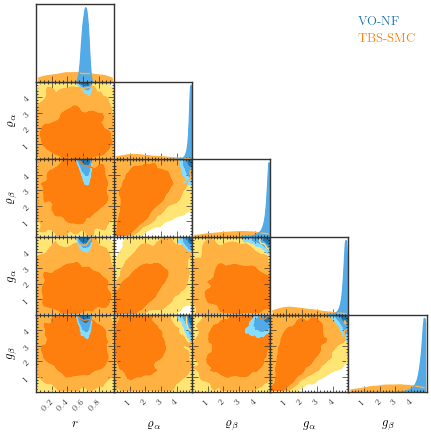

In [26]:
f = pygtc.plotGTC([samples_flow.numpy(), samples_abc], nContourLevels=3,
              paramNames = ["$r$", r"$\varrho_\alpha$", r"$\varrho_\beta$", r"$g_\alpha$", r"$g_\beta$"],
              figureSize='MNRAS_page', chainLabels=["VO-NF", "TBS-SMC"]);
# f.savefig("../figures/paper/ultravox_populi_cornerplot.pdf", bbox_inches='tight')